In [2]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

In [3]:
DATAPATH = 'data/'

In [4]:
data = pd.read_csv(DATAPATH+'openfoodfacts.csv',delimiter='\t',low_memory=True)

C:\Users\johan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,42,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data_=data.dropna(subset=['labels_tags'])

In [6]:
#np.set_printoptions(threshold=np.nan)

vegan_set=data_[data_['labels_tags'].str.contains('vegan').fillna(False) & (~ data_['labels_tags'].str.contains('no-vegan').fillna(False)) ]

In [7]:
origin_lists=vegan_set.origins_tags.dropna().str.split(',')

In [8]:
origin_exploded=origin_lists.apply(pd.Series).unstack()

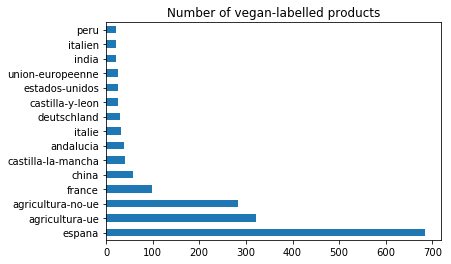

In [9]:
origin_exploded.value_counts().head(15).plot.barh()
plt.title('Number of vegan-labelled products')
plt.show()

In [10]:
total_origins=data.origins_tags.dropna().str.split(',')
total_origins_exploded=total_origins.apply(pd.Series).unstack()

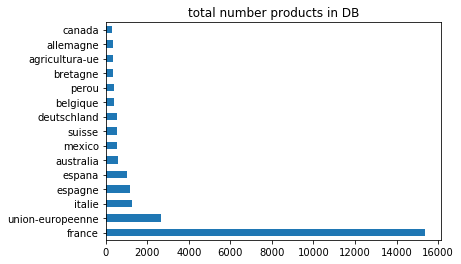

In [12]:
total_origins_exploded.value_counts().head()
total_origins_exploded.value_counts().head(15).plot.barh()
plt.title('total number products in DB')
plt.show()


In [15]:
vegan_origin_df=origin_exploded.to_frame().reset_index().drop(labels=['level_0'],axis=1)
total_origin_df=total_origins_exploded.to_frame().reset_index().drop(labels=['level_0'],axis=1)

In [16]:
total_origin_df.columns=['level_1','origin']
total_origin_df=total_origin_df.dropna()

In [17]:
total_count=total_origin_df.groupby(by=['origin']).size().sort_values(ascending=False).to_frame()

In [18]:
vegan_origin_df.columns=['level_1', 'vegan_loc']

In [19]:
vegan_count=vegan_origin_df.groupby(by=['vegan_loc']).size().to_frame()



In [20]:
comparison=pd.merge(total_count,vegan_count,right_index=True,left_index=True,how='inner')

# Comment on data

The origins_tags series is messy.

First of all, same country entries are in different languange. The first approach is to deal with similar strings clustering: put together italy, italia and italien, but it would not work for austria osterreich as well as Germany Allemagne and Republica Federale Tedesca.

Another problem is the bias of the data base: it is a french data base, so will have more entries and more details for product from France, and frome Europe in a lower extend. To overcome that problem, we want to compare countries by their relative vegan production (vegan labelled production from one origin_tag over total production from the same).

But this solution shows a third problem: irrelevent tags. Some tags are to precise: regions or province, or even wrong ('soja' is not a country). For these tags are very rare, it is possible to have a confidence (the ratio that we talked about) of 100%: for instance, there is only one product tagged 'zamora-provincia' and this product is also tagged vegan, then 'zamora-provincia' will be the "vegan champion", but this is irrelevant to compare a precise province with entire country.

We addressed that last problem by thresholding the support (at 100 labbeled products), so we are sure to retrieve frequent countriews in the DB. Also we manually removed too general labelled because those can have a high support as well ('eu').

In [27]:
relevent_index=['aceitunas', 'afrique', 'agadir', 'agypten', 'alava', 'albacete-provincia', 'albatera', 'alemania', 'alicante', 'alicante-provincia', 'allemagne', 'almendras', 'almeria-provincia', 'almunecar', 'alps', 'amandes-d-italie', 'amazonas', 'amazonie', 'america-del-sur', 'amerique', 'amerique-centrale', 'amerique-du-nord', 'amerique-du-sud', 'andalucia', 'andes', 'angleterre', 'angleterre-betterave', 'aragon', 'aranjuez', 'argelia', 'argentina', 'argentinien', 'arroz', 'asie', 'asie-pour-le-fruit-de-moines', 'asturias', 'atlantico-suroeste', 'australia', 'austria', 'autol', 'autriche', 'avoine-francaise', 'azucar', 'azur-quelle', 'bajo-aragon', 'bali', 'batata', 'belgica', 'belgien', 'belgium', 'bolivia', 'bolivie', 'bolivien', 'bosnien-herzegowina', 'brazil', 'bresil', 'bretagne', 'burkina-faso', 'cacahuetes', 'cacao', 'caceres-provincia', 'cadiz-provincia', 'caldes-de-malavella', 'calera-y-chozas', 'california', 'californie', 'camargue', 'cambrils', 'cana-de-azucar', 'canada', 'casas-de-haro', 'castilla-la-mancha', 'castilla-y-leon', 'cataluna', 'cevennes', 'chile', 'china', 'chine', 'chufa', 'ciego-montero', 'cienfuegos', 'ciruelas', 'ciudad-real-provincia', 'col', 'col-lombarda', 'colombia', 'columbia', 'commerce-equitable', 'comunidad-valenciana', 'conil-de-la-frontera', 'cordoba-provincia', 'corea', 'costa-de-galicia', 'costa-de-marfil', 'costa-rica', 'cuba', 'cuenca-provincia', 'desconocido', 'deutschland', 'dominikanische-republik', 'e-u-a', 'ecuador', 'egipto', 'egnil', 'egypte', 'el-bolson', 'el-mirador', 'equateur', 'esmeraldas', 'espagne', 'espana', 'estados-unidos', 'etats-unis','eutschland', 'extremadura', 'filderstadt', 'filipinas', 'fontanilles', 'fougerolles', 'france', 'francia', 'frankreich', 'fresas', 'fuera-de-espana', 'galicia', 'gard', 'garray', 'germany', 'gerona-provincia', 'gers', 'gers-en-france-pour-le-ble', 'ghana', 'girona', 'golfo-de-vizcaya', 'granada-provincia', 'grece', 'grecia', 'greece', 'griechenland', 'guadalajara-provincia', 'haiti', 'haute-provence', 'herefordshire', 'holanda', 'hongrie','huelva-provincia', 'inde', 'india', 'indien', 'indien-landwirtschaft', 'indonesia', 'indonesie', 'indonesien', 'industria-argentina', 'ingrediente-s', 'iran', 'ireland', 'islas-canarias', 'israel', 'italia', 'italie', 'italien', 'italy', 'jaen', 'japon', 'jativa', 'kanada', 'kenia', 'kirgistan', 'kolumbien', 'la-coruna-provincia', 'la-mancha-comarca', 'la-manchuela-comarca', 'la-montiela-pedania', 'la-orotava', 'la-rioja', 'leimuiden', 'leinfelden-echterdingen', 'lerida-provincia', 'lombardia', 'lomellina', 'madagascar', 'madrid-comunidad-autonoma', 'malaga-provincia', 'malaui', 'manantial-amer-palatin', 'manantial-bezoya-de-trescasas', 'manantial-font-sacalm', 'manantial-fuente-primavera', 'manantial-fuentevera', 'manantial-siguenza', 'manantial-vichy-catalan', 'marinaleda', 'marruecos', 'mazarron', 'melocotones', 'mexico', 'mexiko', 'mexique', 'midlands-de-l-ouest', 'milano', 'minglanilla', 'minho-lima', 'modena', 'montricoux', 'montseny', 'moratilla-de-henares', 'motril', 'munchsteinach', 'murcia', 'murcia-comunidad-autonoma', 'mures-des-pays-bas', 'myrtilles-du-maroc', 'nao-ue', 'nardo', 'navarra', 'niederosterreich', 'niger', 'nijar','nueva-zelanda', 'osterreich', 'pais-vasco', 'pakistan', 'palmira', 'papua-neuguinea', 'paraguay', 'pavia-provincia', 'pays-bas', 'pepinillos', 'perou', 'peru', 'philippinen', 'philippines', 'pichincha-provincia', 'piemont', 'pioz', 'plano-tx', 'poland', 'polonia', 'portugal', 'quintanar-del-rey', 'regiao-do-norte', 'region-centro-norte', 'reino-unido', 'remolacha-y-zanahoria', 'republica-dominicana', 'republique-dominicaine', 'requena', 'requena-utiel-comarca', 'rheinland', 'ribera-del-jalon-comarca', 'rice', 'rio-negro', 'riz', 'romania', 'roumanie', 'royaume-uni', 'rugen', 'rumanien', 'salamanca-provincia', 'san-antonio-requena', 'sant-hilari-sacalm', 'santa-cruz-de-tenerife-provincia', 'santaella', 'santo-domingo', 'santo-tome-y-principe', 'sao-tome', 'sao-tome-und-principe', 'schweden', 'segovia-provincia', 'selva-comarca', 'serbia', 'sevilla-provincia', 'sicile', 'sierra-de-gredos', 'siguenza', 'slowakei', 'soja', 'soja-bio', 'soja-de-france', 'soja-de-francia', 'soja-europeen', 'soja-origine-france', 'soja-sud-est', 'soria-provincia', 'south-africa', 'south-africa-local-and-imported', 'spain', 'spanien', 'sri-lanka', 'sud-est-de-la-france', 'sud-ouest', 'sud-ouest-de-la-france', 'sudafrica', 'sudafrika', 'sudamerica', 'sudamerika', 'suisse', 'switzerland', 'tailandia', 'tanzania', 'tanzanie', 'tarn-et-garonne', 'tarragona-provincia', 'thailand', 'thailande', 'toledo-provincia', 'tomates', 'tozeur', 'trentino-alto-adigio', 'trescasas', 'trinidad', 'trinidad-und-tobago', 'tunesien', 'tunez', 'tunisia', 'tunisie', 'turkei', 'turquia', 'turquie', 'uca', 'ucrania', 'ue', 'ue-non-ue', 'uganda', 'ukraine',  'united-kingdom', 'united-states', 'united-states-of-america', 'usa', 'usa-and-other-unspecified-countries', 'val-venosta', 'valencia', 'valencia-provincia', 'valladolid-provincia', 'vancouver-bc', 'various', 'venezie', 'venezuela', 'verin', 'viana-do-castelo', 'viana-do-castelo-distrito', 'vietnam', 'villa-del-prado', 'villalgordo-del-jucar', 'villamalea', 'villanueva-de-la-jara', 'waldviertel', 'west-indies', 'wiesbaum', 'yuca', 'zamora-provincia', 'zaragoza-provincia' ] 

In [28]:
relevent_comparison=comparison.loc[relevent_index]
relevent_comparison=relevent_comparison[relevent_comparison['0_x']>100]


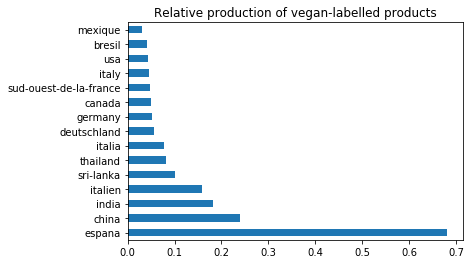

In [29]:
relevent_comparison['ratio']=relevent_comparison['0_y']/relevent_comparison['0_x']
relevent_comparison.ratio.sort_values(ascending=False).head(15).plot.barh()
plt.title('Relative production of vegan-labelled products')
plt.show()

# Comment on observations

Spain is the country that produce the higher part of vegan product relatively to its total production.
A solution is to check the categories

In [ ]:
vegan_set["created_datetime"] = pd.to_datetime(vegan_set["created_datetime"],errors="coerce")
dateparsed = vegan_set[vegan_set["created_datetime"].notnull()]

In [ ]:
vegan_date=dateparsed.reset_index().set_index('created_datetime')

In [ ]:
vegan_date["count"] = 1
vegan_date = vegan_date["count"].resample("30D").sum()
vegan_date.plot.line(title="Trend of articles containing palm oil over time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

In [ ]:
vegan_date.cumsum().plot.line()
plt.show()

In [14]:
fat_set=data.dropna(subset=['fat_100g'])

In [ ]:
data_